In [122]:
import sys
import numpy as np
import matplotlib.pyplot as plt
# import pygame as pg
from scipy.spatial import Delaunay
import time
from geompreds import orient2d, incircle
import gmsh
import sys
from bisect import bisect
from collections import deque

In [123]:
class TriangularMesh:
    def __init__(self, vertices=None, faces=None, halfedges=None):
        self.vertices = [] if vertices == None else vertices
        self.faces = [] if faces == None else faces
        self.halfedges = [] if halfedges == None else halfedges
        self.version = int(sys.version.split('.')[1]) >= 10

    def sort_vertices(self):
        self.vertices.sort(key=lambda x: x.Hilbert)

    def add_triangle(self, vertices, halfedges=None):
        halfedges = halfedges if halfedges else [Halfedge() for _ in range(3)]
        face = Face(halfedges[0])
        for i in range(3):
            halfedges[i].next = halfedges[i-2]
            halfedges[i].prev = halfedges[i-1]
            halfedges[i].vertex = vertices[i]
            halfedges[i].facet = face
            vertices[i].halfedge = halfedges[i]
        self.halfedges += halfedges
        self.faces.append(face)
        return halfedges
    
    def rem_halfedge(self, halfedge):
        self.halfedges.remove(halfedge)
        del halfedge
    
    def add_Hvertex(self, coords, halfedge, Hilbert, index=None):
        if self.version:
            ind = bisect(self.vertices, Vertex(Hilbert=Hilbert), key=lambda x: x.Hilbert)
            self.vertices.insert(ind, Vertex(coords, halfedge, Hilbert, index))
        else:
            self.vertices.append(Vertex(coords, halfedge, Hilbert, index))
            self.vertices.sort(key=lambda x: x.Hilbert)
            ind = self.vertices.index(Vertex(coords, halfedge, Hilbert, index))
        return ind
    
    def add_Hvertices(self, vertices):
        self.vertices += vertices
        self.vertices.sort(key=lambda x: x.Hilbert)
        return list(filter(lambda i: self.vertices[i] in vertices, range(len(self.vertices))))
    
    def add_mesh(self, mesh):
        self.vertices += mesh.vertices
        # self.vertices.sort(key=lambda x: x.Hilbert)
        self.faces += mesh.faces
        self.halfedges += mesh.halfedges

    def rem_mesh(self, mesh):
        self.vertices = list(filter(lambda v: v not in mesh.vertices, self.vertices))
        self.faces = list(filter(lambda f: f not in mesh.faces, self.faces))
        self.halfedges = list(filter(lambda h: h not in mesh.halfedges, self.halfedges))

class Vertex:
    def __init__(self, coords=None, halfedge=None, Hilbert=None, next=None, prev=None, index=None):
        self.coords = coords
        self.halfedge = halfedge
        self.Hilbert = Hilbert
        self.next = next
        self.prev = prev
        self.index = index

    def __repr__(self):
        return f"({self.coords[0]:.4g}, {self.coords[1]:.4g})"

class Face:
    def __init__(self, halfedge=None, visited=False, index=None):
        self.halfedge = halfedge # halfedge going ccw around this facet
        self.visited = visited
        self.index = index
    
    def __repr__(self):
        return f"[{self.halfedge.vertex} {self.halfedge.next.vertex} {self.halfedge.prev.vertex}]"

class Halfedge:
    def __init__(self, next=None, prev=None, twin=None, vertex=None, facet=None, index=None):
        self.next = next
        self.prev = prev
        self.twin = twin
        self.vertex = vertex
        self.facet = facet
        self.index = index

    def __repr__(self):
        return f"{self.vertex} -> {self.next.vertex}"

In [ ]:
print(f"{str(np.round((0.3453565, 1.93242425), 2).tolist())}")

In [3]:
arr = [np.random.rand(2) for i in range(1000)]

In [ ]:
%timeit arr2 = list(map(lambda x: (x[0], x[1]), arr))

In [ ]:
%timeit list(map(tuple, arr))
orient2d()

In [124]:
input_file = 'pts.dat' if '-i' not in sys.argv else sys.argv[sys.argv.index('-i') + 1]
output_file = 'triangles.dat' if '-o' not in sys.argv else sys.argv[sys.argv.index('-o') + 1]

In [125]:
points = np.random.rand(2, 10).T if input_file == '' else np.loadtxt(input_file, skiprows=1)
N = len(points)
border = [min(points[:, 0]), max(points[:, 0]), min(points[:, 1]), max(points[:, 1])]

Time: 0.00398707389831543


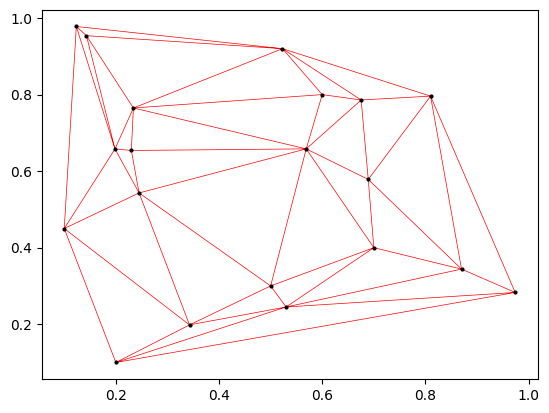

In [126]:
# expected result
start = time.time()
tri = Delaunay(points)
print('Time:', time.time() - start)
plt.triplot(points[:,0], points[:,1], tri.simplices, 'r-', linewidth=0.5)
plt.plot(points[:,0], points[:,1], 'ko', markersize=2)
plt.show()

In [127]:
def Hilbert(point, depth, O, R, B):
    point, O, R, B = map(np.array, [point, O, R, B])
    index = [0] * depth
    for i in range(depth):
        dotR = np.dot(point-O, R) > 0.
        dotB = np.dot(point-O, B) > 0.
        R /= 2.
        B /= 2.
        if dotR:
            if dotB:
                index[i] = 2
                O += R + B
            else:
                index[i] = 3
                O += R - B
                R, B = B, R
        else:
            if dotB:
                index[i] = 1
                O -= R - B
            else:
                index[i] = 0
                O -= R + B
                R, B = B, R
    return index

In [128]:
def Ball(boundary, p):
    # connect p to all vertices of the cavity
    N = len(boundary.vertices)
    new_mesh = TriangularMesh(vertices=boundary.vertices+[p])
    boundary.halfedges.sort(key=lambda hedge: hedge.next.vertex.coords)
    next_bdry_hedges = sorted(boundary.halfedges, key=lambda hedge: hedge.vertex.coords)
    for hedge in boundary.halfedges:
        new_mesh.add_triangle([p, hedge.vertex, hedge.next.vertex], [Halfedge(), hedge, Halfedge()])
        # if hedge.twin:
        #     hedge.twin.twin = new_mesh.halfedges[-2]
        #     new_mesh.halfedges[-2].twin = hedge.twin
        #     print('twin', hedge.twin, new_mesh.halfedges[-2])
        print('twin', hedge.twin, new_mesh.halfedges[-2])

        # hedge.next = new_mesh.halfedges[-1] # for getting to triangle when stitching
    for i, hedge in enumerate(boundary.halfedges):
        hedge.next.twin = next_bdry_hedges[i].next.next
        next_bdry_hedges[i].next.next.twin = hedge.next

    return new_mesh

In [8]:
a, b, c = (2., 3.), (np.inf, -np.inf), (np.inf, np.inf)
sum(map(lambda x: (np.array(x)>0) * np.isinf(x), [a, b, c]))
tuple(map(lambda x: (np.array(x)>0) * np.isinf(x), [a, b, c]))
tuple(sum(x) for x in zip(a, b, c))
# %timeit next(filter(lambda x: not np.isinf(x[0]), (a,b,c)))

(inf, nan)

In [9]:
if np.isinf((-np.inf, np.inf))[0]:
    print('yes')

yes


In [129]:
def Cavity(mesh, p, ind):
    # find a triangle containing p
    def check_triangle(halfedge):
        # print(halfedge.vertex.coords)
        # print(halfedge.next.vertex.coords)
        # print(halfedge.prev.vertex.coords)
        a, b, c = halfedge.vertex.coords, halfedge.next.vertex.coords, halfedge.prev.vertex.coords
        res = incircle(a, b, c, p.coords)
        if np.isnan(res):
            # number of None in [a, b, c]
            k = [halfedge.twin, halfedge.next.twin, halfedge.prev.twin].count(None)
            if k == 0:
                # do orient2d test instead
                a, b = (a, b) if np.isinf(c[0]) else (b, c) if np.isinf(a[0]) else (c, a)
                # return orient2d(a, b, p.coords) >= 0 or orient2d(b, c, p.coords) >= 0 or orient2d(c, a, p.coords) >= 0
                res1 = orient2d(a, b, p.coords)
                return res1 >= 0
            elif k == 1:
                # find index of non infinite point in [a, b, c]
                d = a if not np.isinf(a[0]) else b if not np.isinf(b[0]) else c
                quadrant = tuple(sum(x) for x in zip(a, b, c)) # (+inf, nan) (nan, +inf) (-inf, nan) (nan, -inf)
                if np.isnan(quadrant[1]):
                    return p.coords[0] >= d[0] if quadrant[0] > 0 else p.coords[0] <= d[0]
                else:
                    return p.coords[1] >= d[1] if quadrant[1] > 0 else p.coords[1] <= d[1]
            else:
                print('Error: 3 infinite points in triangle')
                print(a, b, c)

        return res >= 0

    def check_vertex(vertex):
        halfedge = vertex.halfedge
        if not halfedge:
            print('no edge for vertex', vertex)
            return None
        while True:
            if check_triangle(halfedge):
                return halfedge
            if halfedge.twin == None:
                break
            halfedge = halfedge.twin.next # clockwise
            if halfedge == vertex.halfedge:
                break
            if halfedge.vertex != vertex:
                print('not good', halfedge, halfedge.vertex, vertex)
                break
        return None
    
    def expand(init_hedge):
        interior = TriangularMesh(faces=[init_hedge.facet])
        boundary = TriangularMesh()

        visited = []
        stack = deque([init_hedge, init_hedge.next, init_hedge.prev])
        while stack:
            hedge = stack.popleft()
            if hedge.twin == None:
                boundary.halfedges.append(hedge)
                boundary.vertices.append(hedge.vertex)
                continue
            if hedge.twin.facet.visited or not check_triangle(hedge.twin):
                boundary.halfedges.append(hedge)
                boundary.vertices.append(hedge.vertex)
                continue
            hedge.twin.facet.visited = True
            visited.append(hedge.twin.facet)
            interior.halfedges += [hedge, hedge.twin]
            interior.faces.append(hedge.twin.facet)

            stack.append(hedge.twin.next)
            stack.append(hedge.twin.prev)

        for face in visited:
            face.visited = False
        
        print('inbdr', boundary.vertices)
        return interior, boundary
    
    i = 2
    while True:
        u = mesh.vertices[(ind + (-1)**i * i // 2)%len(mesh.vertices)]
        init_hedge = check_vertex(u)
        # print(u.coords)
        if init_hedge:
            break
        i += 1
    
    # print(init_hedge.vertex.coords, init_hedge.next.vertex.coords, init_hedge.prev.vertex.coords)

    res = expand(init_hedge)
    return res


In [153]:
points

array([[0.2     , 0.1     ],
       [0.7     , 0.4     ],
       [0.1     , 0.45    ],
       [0.6     , 0.8     ],
       [0.5     , 0.3     ],
       [0.23    , 0.654   ],
       [0.523   , 0.92    ],
       [0.81    , 0.796   ],
       [0.143   , 0.954   ],
       [0.87    , 0.344   ],
       [0.53    , 0.245   ],
       [0.234   , 0.765   ],
       [0.1983  , 0.657884],
       [0.34278 , 0.1982  ],
       [0.67548 , 0.78592 ],
       [0.569   , 0.6582  ],
       [0.12334 , 0.978   ],
       [0.245   , 0.543   ],
       [0.6892  , 0.57839 ],
       [0.974   , 0.283   ]])

In [154]:
# np.inf = 1.15 # bad for testing as code relies on inf

In [155]:
depth = 8
O, R, B = (0.5, 0.5), (0.5, 0), (0, 0.5)
mesh = TriangularMesh()
for p in points:
    mesh.vertices.append(Vertex(tuple(p.tolist()), Hilbert=Hilbert(p, depth, O, R, B)))

In [156]:
# add points at +-infinity
infite_pts = [(np.inf, np.inf), (-np.inf, np.inf), (-np.inf, -np.inf), (np.inf, -np.inf)] # keep order!
mesh.vertices += list(map(lambda x: Vertex(x, Hilbert=[-1]*depth), infite_pts))
mesh.sort_vertices()
for p in mesh.vertices:
    print(p.coords, p.Hilbert)

(inf, inf) [-1, -1, -1, -1, -1, -1, -1, -1]
(-inf, inf) [-1, -1, -1, -1, -1, -1, -1, -1]
(-inf, -inf) [-1, -1, -1, -1, -1, -1, -1, -1]
(inf, -inf) [-1, -1, -1, -1, -1, -1, -1, -1]
(0.2, 0.1) [0, 0, 3, 2, 3, 0, 1, 2]
(0.34278, 0.1982) [0, 1, 3, 2, 0, 1, 2, 1]
(0.5, 0.3) [0, 2, 1, 1, 2, 2, 1, 1]
(0.1, 0.45) [0, 3, 1, 2, 3, 0, 1, 2]
(0.245, 0.543) [1, 0, 1, 1, 2, 1, 2, 3]
(0.23, 0.654) [1, 0, 2, 1, 1, 3, 2, 1]
(0.1983, 0.657884) [1, 0, 2, 1, 3, 0, 1, 0]
(0.12334, 0.978) [1, 1, 1, 2, 2, 3, 2, 1]
(0.143, 0.954) [1, 1, 2, 1, 0, 2, 0, 0]
(0.234, 0.765) [1, 1, 3, 1, 1, 0, 2, 2]
(0.6892, 0.57839) [2, 0, 1, 2, 0, 1, 0, 0]
(0.569, 0.6582) [2, 0, 3, 3, 3, 0, 0, 3]
(0.6, 0.8) [2, 1, 0, 1, 2, 3, 0, 1]
(0.523, 0.92) [2, 1, 1, 0, 3, 3, 3, 2]
(0.67548, 0.78592) [2, 1, 3, 0, 2, 3, 0, 1]
(0.81, 0.796) [2, 2, 0, 0, 2, 3, 2, 2]
(0.53, 0.245) [3, 0, 1, 1, 1, 2, 2, 3]
(0.87, 0.344) [3, 2, 0, 2, 2, 3, 1, 0]
(0.974, 0.283) [3, 2, 1, 1, 2, 0, 0, 1]
(0.7, 0.4) [3, 3, 2, 3, 0, 1, 2, 3]


In [157]:
# add the 4 initial triangles with infinite points and point p[0]
p = mesh.vertices[4]
for i in range(4):
    mesh.add_triangle([mesh.vertices[i], mesh.vertices[(i+1)%4], mesh.vertices[4]])
# stick edges together
for i in range(4):
    mesh.halfedges[3*i + 1].twin = mesh.halfedges[(3*i + 5) % 12]
    mesh.halfedges[(3*i + 5) % 12].twin = mesh.halfedges[3*i + 1]

In [158]:
print(mesh.vertices)
print(mesh.halfedges)
print(mesh.faces)

[(inf, inf), (-inf, inf), (-inf, -inf), (inf, -inf), (0.2, 0.1), (0.3428, 0.1982), (0.5, 0.3), (0.1, 0.45), (0.245, 0.543), (0.23, 0.654), (0.1983, 0.6579), (0.1233, 0.978), (0.143, 0.954), (0.234, 0.765), (0.6892, 0.5784), (0.569, 0.6582), (0.6, 0.8), (0.523, 0.92), (0.6755, 0.7859), (0.81, 0.796), (0.53, 0.245), (0.87, 0.344), (0.974, 0.283), (0.7, 0.4)]
[(inf, inf) -> (-inf, inf), (-inf, inf) -> (0.2, 0.1), (0.2, 0.1) -> (inf, inf), (-inf, inf) -> (-inf, -inf), (-inf, -inf) -> (0.2, 0.1), (0.2, 0.1) -> (-inf, inf), (-inf, -inf) -> (inf, -inf), (inf, -inf) -> (0.2, 0.1), (0.2, 0.1) -> (-inf, -inf), (inf, -inf) -> (inf, inf), (inf, inf) -> (0.2, 0.1), (0.2, 0.1) -> (inf, -inf)]
[[(inf, inf) (-inf, inf) (0.2, 0.1)], [(-inf, inf) (-inf, -inf) (0.2, 0.1)], [(-inf, -inf) (inf, -inf) (0.2, 0.1)], [(inf, -inf) (inf, inf) (0.2, 0.1)]]


In [159]:
def draw_mesh(mesh):
    for he in mesh.halfedges:
        # if he.visited:
        #     continue
        a, b = he.vertex.coords, he.next.vertex.coords
        # plt.plot(*np.clip((a, b), -0.1, 1.1).T, 'r-')
        plt.plot(*zip(a, b), 'r-')
        # plt.arrow(a[0], a[1], b[0]-a[0], b[1]-a[1], head_width=0.5, head_length=1, fc='r', ec='k')
    for p in mesh.vertices:
        plt.plot(*p.coords, 'ko')
    plt.show()

# draw_mesh(mesh)

In [160]:
vertices = mesh.vertices[5:]
mesh.vertices = mesh.vertices[:5]

In [161]:
print(vertices)
print(mesh.vertices)

[(0.3428, 0.1982), (0.5, 0.3), (0.1, 0.45), (0.245, 0.543), (0.23, 0.654), (0.1983, 0.6579), (0.1233, 0.978), (0.143, 0.954), (0.234, 0.765), (0.6892, 0.5784), (0.569, 0.6582), (0.6, 0.8), (0.523, 0.92), (0.6755, 0.7859), (0.81, 0.796), (0.53, 0.245), (0.87, 0.344), (0.974, 0.283), (0.7, 0.4)]
[(inf, inf), (-inf, inf), (-inf, -inf), (inf, -inf), (0.2, 0.1)]


In [162]:
# p = vertices[0]
# interior, boundary = Cavity(mesh, p, 5)
# print('bdrv', boundary.vertices)
# print('int', interior.halfedges)
# ball = Ball(boundary, p)
# print('ballv', ball.vertices)
# print('ballh', ball.halfedges)

In [163]:
# draw_mesh(ball)
# mesh.rem_mesh(boundary)
# mesh.rem_mesh(interior)
# mesh.add_mesh(ball)
# print(mesh.vertices, end='\n\n')
# print(mesh.halfedges, end='\n\n')
# print(mesh.faces)

inbdr [(inf, -inf), (0.2, 0.1), (inf, inf), (-inf, inf)]
twin None (inf, inf) -> (-inf, inf)
twin (0.2, 0.1) -> (-inf, inf) (-inf, inf) -> (0.2, 0.1)
twin (inf, -inf) -> (0.2, 0.1) (0.2, 0.1) -> (inf, -inf)
twin None (inf, -inf) -> (inf, inf)


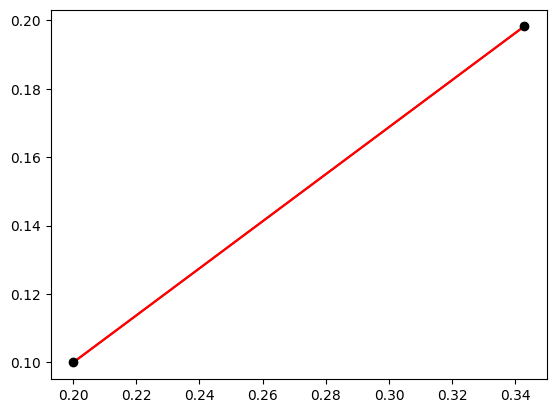

inbdr [(inf, -inf), (inf, inf), (-inf, inf), (0.3428, 0.1982), (0.2, 0.1)]
twin None (inf, inf) -> (-inf, inf)
twin (0.2, 0.1) -> (0.3428, 0.1982) (0.3428, 0.1982) -> (0.2, 0.1)
twin (0.3428, 0.1982) -> (-inf, inf) (-inf, inf) -> (0.3428, 0.1982)
twin (inf, -inf) -> (0.2, 0.1) (0.2, 0.1) -> (inf, -inf)
twin None (inf, -inf) -> (inf, inf)


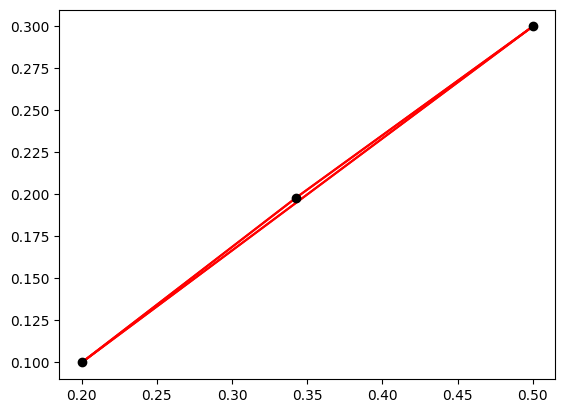

inbdr [(-inf, inf), (-inf, -inf), (0.2, 0.1), (0.3428, 0.1982), (0.5, 0.3), (inf, inf)]
twin None (-inf, inf) -> (-inf, -inf)
twin None (inf, inf) -> (-inf, inf)
twin (0.2, 0.1) -> (-inf, -inf) (-inf, -inf) -> (0.2, 0.1)
twin (0.3428, 0.1982) -> (0.2, 0.1) (0.2, 0.1) -> (0.3428, 0.1982)
twin (0.5, 0.3) -> (0.3428, 0.1982) (0.3428, 0.1982) -> (0.5, 0.3)
twin (inf, inf) -> (0.5, 0.3) (0.5, 0.3) -> (inf, inf)


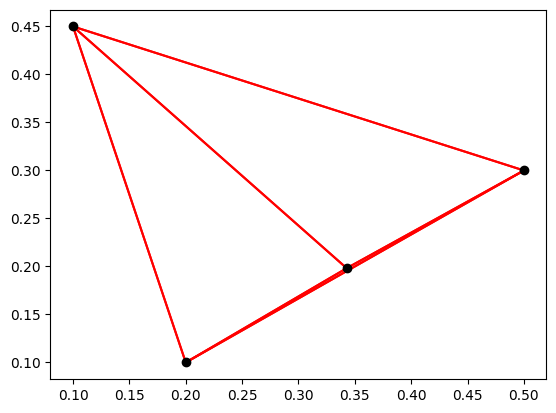

inbdr [(-inf, inf), (inf, inf), (0.5, 0.3), (0.1, 0.45), (0.3428, 0.1982)]
twin None (inf, inf) -> (-inf, inf)
twin (0.1, 0.45) -> (-inf, inf) (-inf, inf) -> (0.1, 0.45)
twin (0.3428, 0.1982) -> (0.1, 0.45) (0.1, 0.45) -> (0.3428, 0.1982)
twin (0.5, 0.3) -> (0.3428, 0.1982) (0.3428, 0.1982) -> (0.5, 0.3)
twin (inf, inf) -> (0.5, 0.3) (0.5, 0.3) -> (inf, inf)


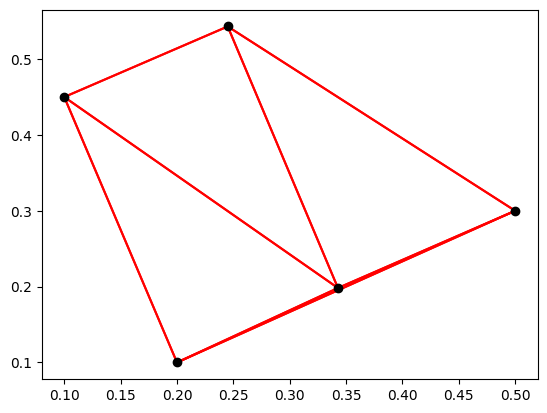

inbdr [(0.1, 0.45), (-inf, inf), (inf, inf), (0.245, 0.543), (0.5, 0.3)]
twin None (inf, inf) -> (-inf, inf)
twin (0.1, 0.45) -> (-inf, inf) (-inf, inf) -> (0.1, 0.45)
twin (0.245, 0.543) -> (0.1, 0.45) (0.1, 0.45) -> (0.245, 0.543)
twin (0.5, 0.3) -> (0.245, 0.543) (0.245, 0.543) -> (0.5, 0.3)
twin (inf, inf) -> (0.5, 0.3) (0.5, 0.3) -> (inf, inf)


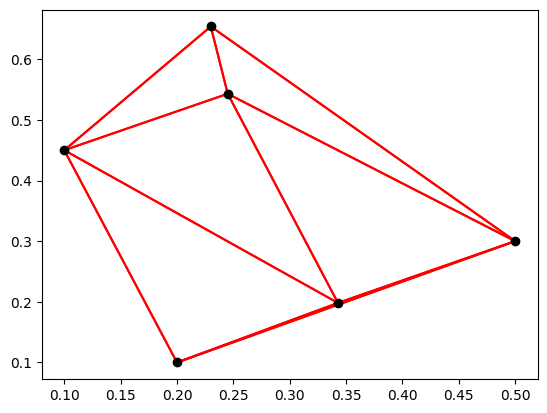

inbdr [(0.245, 0.543), (0.1, 0.45), (-inf, inf), (0.23, 0.654), (inf, inf)]
twin None (inf, inf) -> (-inf, inf)
twin (0.1, 0.45) -> (-inf, inf) (-inf, inf) -> (0.1, 0.45)
twin (0.23, 0.654) -> (0.245, 0.543) (0.245, 0.543) -> (0.23, 0.654)
twin (0.245, 0.543) -> (0.1, 0.45) (0.1, 0.45) -> (0.245, 0.543)
twin (inf, inf) -> (0.23, 0.654) (0.23, 0.654) -> (inf, inf)


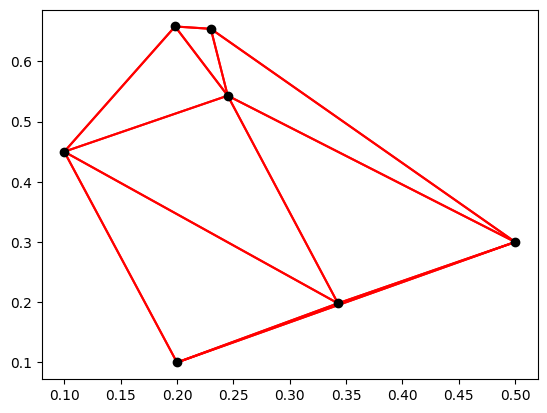

inbdr [(0.1983, 0.6579), (inf, inf), (0.23, 0.654), (0.5, 0.3), (-inf, inf), (0.1, 0.45)]
twin None (inf, inf) -> (-inf, inf)
twin (0.1, 0.45) -> (-inf, inf) (-inf, inf) -> (0.1, 0.45)
twin (0.1983, 0.6579) -> (0.1, 0.45) (0.1, 0.45) -> (0.1983, 0.6579)
twin (0.23, 0.654) -> (0.1983, 0.6579) (0.1983, 0.6579) -> (0.23, 0.654)
twin (0.5, 0.3) -> (0.23, 0.654) (0.23, 0.654) -> (0.5, 0.3)
twin (inf, inf) -> (0.5, 0.3) (0.5, 0.3) -> (inf, inf)


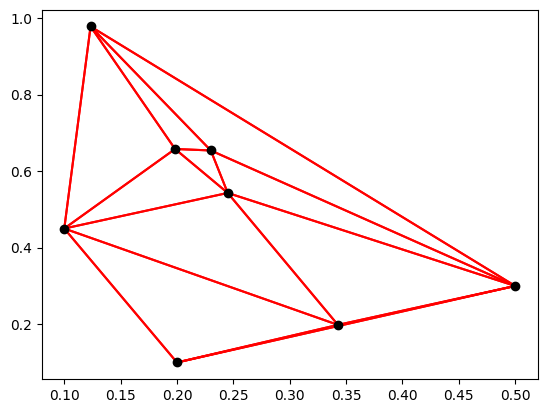

inbdr [(0.5, 0.3), (inf, inf), (0.23, 0.654), (0.1233, 0.978), (0.1983, 0.6579)]
twin (0.1233, 0.978) -> (inf, inf) (inf, inf) -> (0.1233, 0.978)
twin (0.1983, 0.6579) -> (0.1233, 0.978) (0.1233, 0.978) -> (0.1983, 0.6579)
twin (0.23, 0.654) -> (0.1983, 0.6579) (0.1983, 0.6579) -> (0.23, 0.654)
twin (0.5, 0.3) -> (0.23, 0.654) (0.23, 0.654) -> (0.5, 0.3)
twin (inf, inf) -> (0.5, 0.3) (0.5, 0.3) -> (inf, inf)


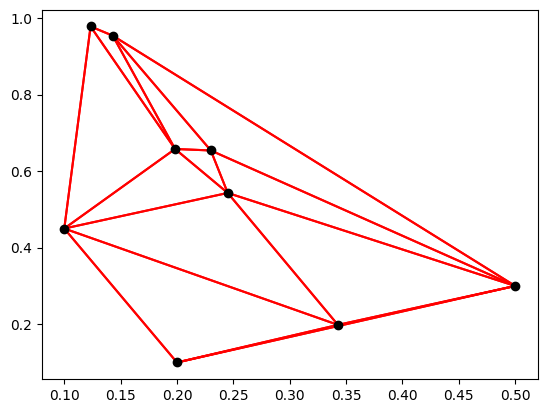

inbdr [(0.1983, 0.6579), (0.143, 0.954), (0.23, 0.654), (0.5, 0.3)]
twin (0.143, 0.954) -> (0.5, 0.3) (0.5, 0.3) -> (0.143, 0.954)
twin (0.1983, 0.6579) -> (0.143, 0.954) (0.143, 0.954) -> (0.1983, 0.6579)
twin (0.23, 0.654) -> (0.1983, 0.6579) (0.1983, 0.6579) -> (0.23, 0.654)
twin (0.5, 0.3) -> (0.23, 0.654) (0.23, 0.654) -> (0.5, 0.3)


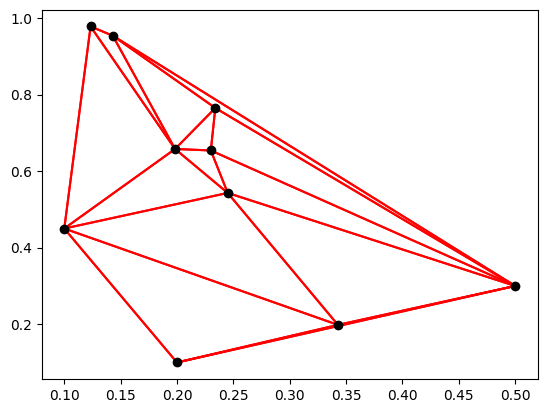

inbdr [(0.234, 0.765), (0.143, 0.954), (0.23, 0.654), (0.245, 0.543), (0.5, 0.3), (inf, -inf), (inf, inf), (0.1233, 0.978)]
twin (0.1233, 0.978) -> (inf, inf) (inf, inf) -> (0.1233, 0.978)
twin (0.143, 0.954) -> (0.1233, 0.978) (0.1233, 0.978) -> (0.143, 0.954)
twin (0.23, 0.654) -> (0.234, 0.765) (0.234, 0.765) -> (0.23, 0.654)
twin (0.234, 0.765) -> (0.143, 0.954) (0.143, 0.954) -> (0.234, 0.765)
twin (0.245, 0.543) -> (0.23, 0.654) (0.23, 0.654) -> (0.245, 0.543)
twin (0.5, 0.3) -> (0.245, 0.543) (0.245, 0.543) -> (0.5, 0.3)
twin (inf, -inf) -> (0.5, 0.3) (0.5, 0.3) -> (inf, -inf)
twin None (inf, -inf) -> (inf, inf)


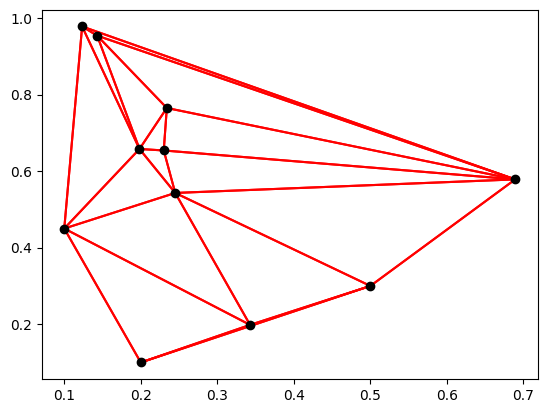

inbdr [(0.1233, 0.978), (0.6892, 0.5784), (0.143, 0.954), (0.234, 0.765), (0.23, 0.654), (0.245, 0.543), (0.5, 0.3)]
twin (0.1233, 0.978) -> (0.6892, 0.5784) (0.6892, 0.5784) -> (0.1233, 0.978)
twin (0.143, 0.954) -> (0.1233, 0.978) (0.1233, 0.978) -> (0.143, 0.954)
twin (0.23, 0.654) -> (0.234, 0.765) (0.234, 0.765) -> (0.23, 0.654)
twin (0.234, 0.765) -> (0.143, 0.954) (0.143, 0.954) -> (0.234, 0.765)
twin (0.245, 0.543) -> (0.23, 0.654) (0.23, 0.654) -> (0.245, 0.543)
twin (0.5, 0.3) -> (0.245, 0.543) (0.245, 0.543) -> (0.5, 0.3)
twin (0.6892, 0.5784) -> (0.5, 0.3) (0.5, 0.3) -> (0.6892, 0.5784)


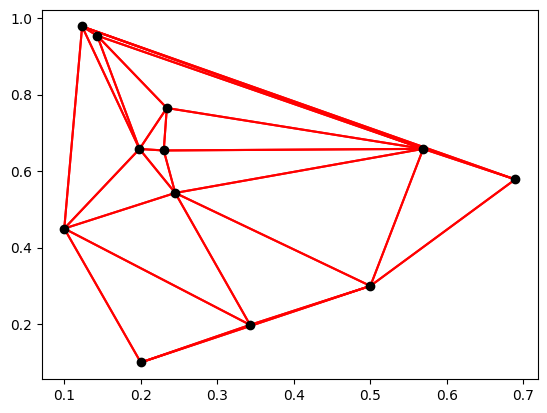

inbdr [(0.234, 0.765), (0.143, 0.954), (0.1233, 0.978), (0.569, 0.6582), (0.6892, 0.5784), (inf, inf)]
twin (0.1233, 0.978) -> (inf, inf) (inf, inf) -> (0.1233, 0.978)
twin (0.143, 0.954) -> (0.1233, 0.978) (0.1233, 0.978) -> (0.143, 0.954)
twin (0.234, 0.765) -> (0.143, 0.954) (0.143, 0.954) -> (0.234, 0.765)
twin (0.569, 0.6582) -> (0.234, 0.765) (0.234, 0.765) -> (0.569, 0.6582)
twin (0.6892, 0.5784) -> (0.569, 0.6582) (0.569, 0.6582) -> (0.6892, 0.5784)
twin (inf, inf) -> (0.6892, 0.5784) (0.6892, 0.5784) -> (inf, inf)


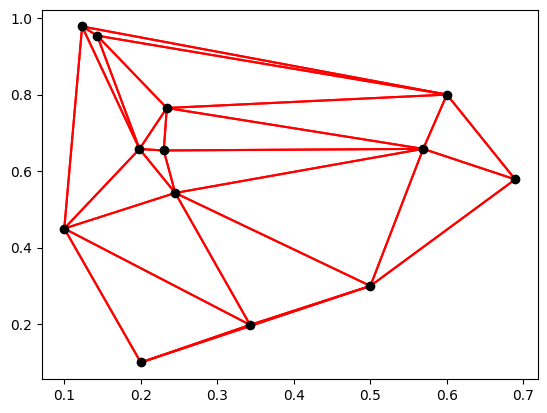

inbdr [(inf, inf), (0.6, 0.8), (0.1233, 0.978), (0.143, 0.954), (0.234, 0.765)]
twin (0.1233, 0.978) -> (inf, inf) (inf, inf) -> (0.1233, 0.978)
twin (0.143, 0.954) -> (0.1233, 0.978) (0.1233, 0.978) -> (0.143, 0.954)
twin (0.234, 0.765) -> (0.143, 0.954) (0.143, 0.954) -> (0.234, 0.765)
twin (0.6, 0.8) -> (0.234, 0.765) (0.234, 0.765) -> (0.6, 0.8)
twin (inf, inf) -> (0.6, 0.8) (0.6, 0.8) -> (inf, inf)


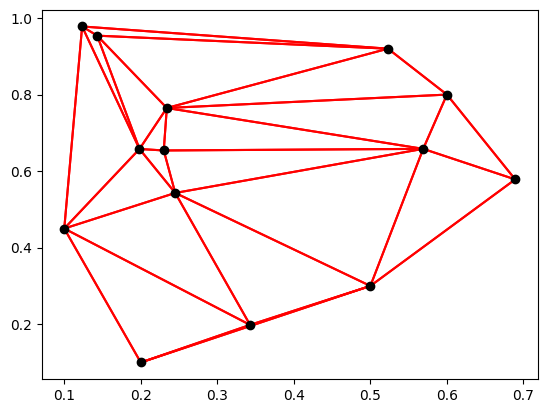

inbdr [(inf, inf), (0.523, 0.92), (0.6892, 0.5784), (0.6, 0.8), (0.569, 0.6582)]
twin (0.523, 0.92) -> (inf, inf) (inf, inf) -> (0.523, 0.92)
twin (0.569, 0.6582) -> (0.6, 0.8) (0.6, 0.8) -> (0.569, 0.6582)
twin (0.6, 0.8) -> (0.523, 0.92) (0.523, 0.92) -> (0.6, 0.8)
twin (0.6892, 0.5784) -> (0.569, 0.6582) (0.569, 0.6582) -> (0.6892, 0.5784)
twin (inf, inf) -> (0.6892, 0.5784) (0.6892, 0.5784) -> (inf, inf)


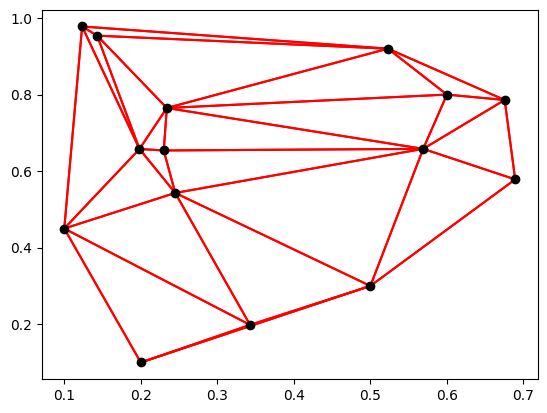

inbdr [(0.6755, 0.7859), (0.6892, 0.5784), (inf, -inf), (inf, inf), (0.523, 0.92)]
twin (0.523, 0.92) -> (inf, inf) (inf, inf) -> (0.523, 0.92)
twin (0.6755, 0.7859) -> (0.523, 0.92) (0.523, 0.92) -> (0.6755, 0.7859)
twin (0.6892, 0.5784) -> (0.6755, 0.7859) (0.6755, 0.7859) -> (0.6892, 0.5784)
twin (inf, -inf) -> (0.6892, 0.5784) (0.6892, 0.5784) -> (inf, -inf)
twin None (inf, -inf) -> (inf, inf)


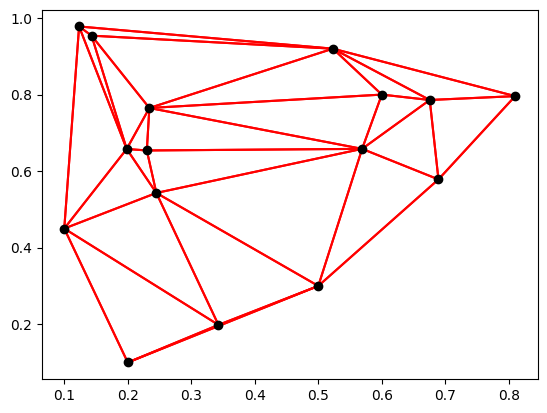

inbdr [(0.5, 0.3), (0.3428, 0.1982), (0.2, 0.1), (0.6892, 0.5784), (inf, -inf), (0.81, 0.796)]
twin (0.2, 0.1) -> (0.3428, 0.1982) (0.3428, 0.1982) -> (0.2, 0.1)
twin (0.3428, 0.1982) -> (0.5, 0.3) (0.5, 0.3) -> (0.3428, 0.1982)
twin (0.5, 0.3) -> (0.6892, 0.5784) (0.6892, 0.5784) -> (0.5, 0.3)
twin (0.6892, 0.5784) -> (0.81, 0.796) (0.81, 0.796) -> (0.6892, 0.5784)
twin (0.81, 0.796) -> (inf, -inf) (inf, -inf) -> (0.81, 0.796)
twin (inf, -inf) -> (0.2, 0.1) (0.2, 0.1) -> (inf, -inf)


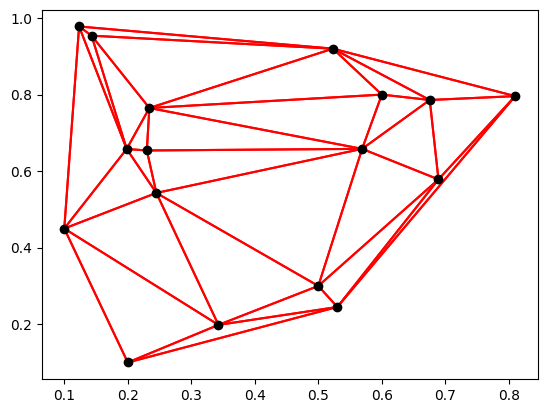

inbdr [(0.81, 0.796), (0.53, 0.245), (0.2, 0.1), (inf, -inf), (inf, inf), (0.6892, 0.5784), (0.5, 0.3)]
twin (0.2, 0.1) -> (0.53, 0.245) (0.53, 0.245) -> (0.2, 0.1)
twin (0.5, 0.3) -> (0.6892, 0.5784) (0.6892, 0.5784) -> (0.5, 0.3)
twin (0.53, 0.245) -> (0.5, 0.3) (0.5, 0.3) -> (0.53, 0.245)
twin (0.6892, 0.5784) -> (0.81, 0.796) (0.81, 0.796) -> (0.6892, 0.5784)
twin (0.81, 0.796) -> (inf, inf) (inf, inf) -> (0.81, 0.796)
twin (inf, -inf) -> (0.2, 0.1) (0.2, 0.1) -> (inf, -inf)
twin None (inf, -inf) -> (inf, inf)


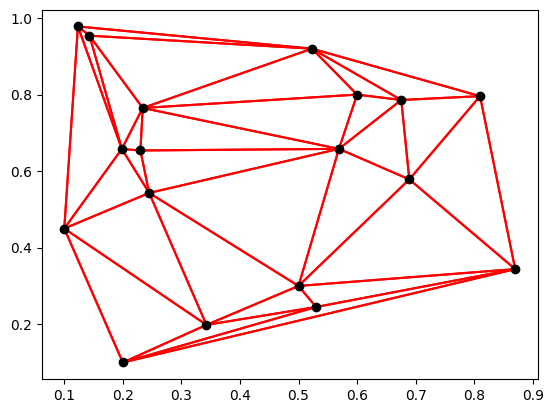

inbdr [(inf, -inf), (inf, inf), (0.81, 0.796), (0.2, 0.1), (0.87, 0.344), (0.53, 0.245)]
twin (0.2, 0.1) -> (0.53, 0.245) (0.53, 0.245) -> (0.2, 0.1)
twin (0.53, 0.245) -> (0.87, 0.344) (0.87, 0.344) -> (0.53, 0.245)
twin (0.81, 0.796) -> (inf, inf) (inf, inf) -> (0.81, 0.796)
twin (0.87, 0.344) -> (0.81, 0.796) (0.81, 0.796) -> (0.87, 0.344)
twin (inf, -inf) -> (0.2, 0.1) (0.2, 0.1) -> (inf, -inf)
twin None (inf, -inf) -> (inf, inf)


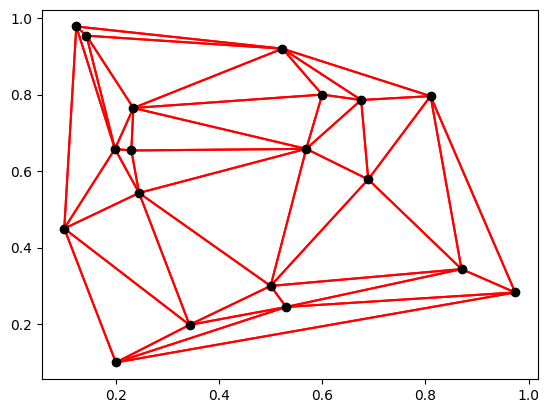

inbdr [(0.53, 0.245), (0.5, 0.3), (0.87, 0.344), (0.6892, 0.5784), (0.569, 0.6582)]
twin (0.5, 0.3) -> (0.569, 0.6582) (0.569, 0.6582) -> (0.5, 0.3)
twin (0.53, 0.245) -> (0.5, 0.3) (0.5, 0.3) -> (0.53, 0.245)
twin (0.569, 0.6582) -> (0.6892, 0.5784) (0.6892, 0.5784) -> (0.569, 0.6582)
twin (0.6892, 0.5784) -> (0.87, 0.344) (0.87, 0.344) -> (0.6892, 0.5784)
twin (0.87, 0.344) -> (0.53, 0.245) (0.53, 0.245) -> (0.87, 0.344)


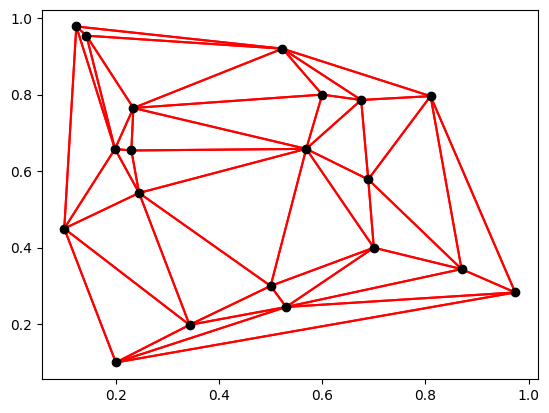

In [164]:

for i in range(19):
    p = vertices[i]
    interior, boundary = Cavity(mesh, p, 5+i)
    # print('bdr', boundary.vertices)
    # print('bdrv', boundary.vertices)
    # print('inth', interior.halfedges)
    ball = Ball(boundary, p)
    # print('ballv', ball.vertices)
    # print('ballh', ball.halfedges)
    # draw_mesh(ball)
    mesh.rem_mesh(boundary)
    mesh.rem_mesh(interior)
    mesh.add_mesh(ball)
    # print('he', len(mesh.halfedges), mesh.halfedges, end='\n')
    # print('meshv', mesh.vertices, end='\n\n')
    draw_mesh(mesh)


# p = vertices[5]
# interior, boundary = Cavity(mesh, p, 5)
# ball = Ball(boundary, p)
# mesh.rem_mesh(boundary)
# mesh.rem_mesh(interior)
# mesh.add_mesh(ball)
# draw_mesh(mesh)

In [ ]:
draw_mesh(mesh)

In [ ]:
interior.halfedges

In [ ]:
test_p = points
test_p = [Vertex(p, index=i) for i, p in enumerate(test_p)]
test_e = [Halfedge(vertex=p) for p in test_p]
test_e = [Halfedge(vertex=p, next=test_e[(i+1)%len(test_e)], prev=test_e[(i-1)%len(test_e)]) for i, p in enumerate(test_p)]
test_mesh = TriangularMesh()
test_mesh.vertices = test_p
test_mesh.halfedges = test_e
# plot points
plt.plot(*zip(*map(lambda x: x.coords, test_mesh.vertices)), 'ko')
# plot edges
for hedge in test_mesh.halfedges:
    # draw arrow
    plt.arrow(*hedge.vertex.coords, hedge.next.vertex.coords[0] - hedge.vertex.coords[0], hedge.next.vertex.coords[1] - hedge.vertex.coords[1], head_width=0.1)
plt.show()

In [ ]:
print(test_mesh.halfedges[0].coords)

In [ ]:
ball = Ball(test_mesh, Vertex((1, 1)), 0)
# plot points
plt.plot(*zip(*map(lambda x: x.coords, ball.vertices)), 'bo')
# plot edges
for abc in ball.halfedges:
    print(abc.vertex.coords, abc.next.vertex.coords)
    plt.plot(*zip(abc.vertex.coords, abc.next.vertex.coords), 'g-')
plt.show()

In [ ]:
def DL(points):
    
    # sort points according to Hilbert curve
    depth = 8
    O = np.array([0.5, 0.5])
    R = np.array([0.5, 0])
    B = np.array([0, 0.5])
    indices = [Hilbert(point, depth, O, R, B) for point in points]
    indices = sorted(range(len(indices)), key=lambda i: indices[i])
    mesh = TriangularMesh()
    # create super triangle
    A = Vertex((border[0] - 1, border[2] - 1))
    B = Vertex((border[1] + 1, border[2] - 1))
    C = Vertex((border[0] + border[1], border[3] + 1))
    super_triangle = Face()
    super_triangle.halfedge = Halfedge(vertex=A, next=Halfedge(vertex=B, next=Halfedge(vertex=C, next=Halfedge(vertex=A, facet=super_triangle))))
    super_triangle.index = 0
    mesh.add_mesh(TriangularMesh(vertices=[A, B, C], faces=[super_triangle], halfedges=[super_triangle.halfedge, super_triangle.halfedge.next, super_triangle.halfedge.next.next, super_triangle.halfedge.next.next.next]))
    for i in indices:
        cavity = Cavity(mesh, Vertex(points[i]), i)
        mesh.add_mesh(Ball(cavity, Vertex(points[i]), i))
    return mesh

In [ ]:
orient2d((0., 0.), (0.5, 0.), (np.inf, -0.1))

In [ ]:
%timeit incircle(np.array([0., 0.]), np.array([1., 0.]), np.array([0., 1.]), np.array([0.5, -0.1]))

In [ ]:
%timeit incircle((0., 0.), (1., 0.), (0., 1.), (0.5, -0.1))

In [ ]:
def test(a, b, c, p):
    # if one of the points has index -1, do orient2d instead of incircle
    if -1 in [a.index, b.index, c.index]:
        return orient2d(a.coords, b.coords, c.coords)


In [ ]:
import math
sys.float_info.max/1e139

In [ ]:
%timeit incircle((0., 0.), (1., 0.), (0., 1.0), (0.5, -0.15))

In [ ]:
%timeit incircle((np.float64(0.), np.float64(0.)), (np.float64(1.), np.float64(0.)), (np.float64(0.), np.float64(1.0)), (np.float64(0.5), np.float64(-0.15)))

In [ ]:
a = [(0., 0.), (1., 0.), (0., 1.0), (0.5, -0.15)]
# a = [[0., 0.], [1., 0.], [0., 1.0], [0.5, -0.15]]
# a = [(np.float64(0.), np.float64(0.)), (np.float64(1.), np.float64(0.)), (np.float64(0.), np.float64(1.0)), (np.float64(0.5), np.float64(-0.15))]
# a = [np.array([0., 0.]), np.array([1., 0.]), np.array([0., 1.0]), np.array([0.5, -0.15])]
# a = np.array([[0., 0.], [1., 0.], [0., 1.0], [0.5, -0.15]])
%timeit incircle(a[0], a[1], a[2], a[3])

In [ ]:
arr = np.random.rand(10000000, 2)
%timeit arr2 = list(map(tuple, arr.tolist()))

In [ ]:
%timeit incircle((np.float32(0.), np.float32(0.)), (np.float32(1.), np.float32(0.)), (np.float32(0.), np.float32(1.0)), (np.float32(0.5), np.float32(-0.15)))

In [ ]:
%timeit incircle((np.float16(0.), np.float16(0.)), (np.float16(1.), np.float16(0.)), (np.float16(0.), np.float16(1.0)), (np.float16(0.5), np.float16(-0.15)))

In [ ]:
%timeit incircle([0., 0.], [1., 0.], [0., 1.], [0.5, -0.1])

In [83]:
a = list(map(tuple, np.random.rand(2, 10).T))

In [ ]:
%timeit incircle(a[0], a[1], a[2], a[3])

In [ ]:
points

In [ ]:
np.random.rand(10, 2)

In [31]:
b = sorted(np.random.rand(100, 2), key=lambda x: Hilbert(x, depth, np.array([0.5, 0.5]), np.array([0.5, 0.]), np.array([0., 0.5])))

In [32]:
insort(b, np.array([0.51, 0.49]), key=lambda x: Hilbert(x, depth, np.array([0.5, 0.5]), np.array([0.5, 0.]), np.array([0., 0.5])))

In [ ]:
for i, p in enumerate(b):
    plt.plot(p[0], p[1], 'ko')
    # write index
    plt.text(p[0], p[1], str(i))
plt.plot(b[-1][0], b[-1][1], 'ro')
plt.show()


In [ ]:
class test:
    def __init__(self, a, b):
        self.a = a
        self.b = b
    def __repr__(self):
        return str(self.a-self.b)

l = [] 
for i in range(10):
    l.append(test(4*i**2, 3*i))

print(l[3].b)